# Yahoo Topic Classification

## Setting up Libraries and Environments

In [1]:
# Basic
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import findspark
import pyspark
from pyspark import SparkFiles

# Data Manipulation
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

# ML
from pyspark.ml.feature import *
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC, OneVsRest, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
findspark.init()

spark = SparkSession.builder.appName('SparkByExamples.com').getOrCreate()

## Data Import

In [3]:
schema_list = [
    StructField('Label', StringType(), False), 
    StructField('Title', StringType(), True), 
    StructField('Content', StringType(), True),
    StructField('Answer', StringType(), True),
    StructField('Set', StringType(), True)
]
schema_df = StructType(fields=schema_list)

In [4]:
# Import Data from reduced folders
df = spark.read.csv("../data/reduced", schema=schema_df)

## Data Preview
This includes some basic view of the data before processing

In [5]:
df.show(5)

+-----+--------------------+--------+--------------------+-----+
|Label|               Title| Content|              Answer|  Set|
+-----+--------------------+--------+--------------------+-----+
|    1|what is the frenc...|    null|Are you talking a...|Train|
|    2|Do we realy need ...|    null|When surfaces are...|Train|
|    5|How can I save my...|    null|"Its 9 way to hac...|Train|
|    7|I'm trying to fin...|help me.|        tagworld.com|Train|
|    7|define Stability ...|    null|A Linear Time Inv...|Train|
+-----+--------------------+--------+--------------------+-----+
only showing top 5 rows



In [6]:
df.describe().show()

+-------+-----------------+--------------------+-----------------------------------+----------------------+------+
|summary|            Label|               Title|                            Content|                Answer|   Set|
+-------+-----------------+--------------------+-----------------------------------+----------------------+------+
|  count|           364615|              364615|                             200607|                357904|364615|
|   mean|5.494765711778177|                null|                           Infinity|              Infinity|  null|
| stddev|2.872483870744461|                null|                                NaN|                   NaN|  null|
|    min|                1|    ! only 4 girls!?|                                  !|  ! - 3 - 7 . Even ...|  Test|
|    max|                9|Describe in your...|黙れこのくそやろう\nむかつくんだ...|혼돈\nhttp://dictio...| Train|
+-------+-----------------+--------------------+-----------------------------------+-------------

## Data Processing

### Steps to Take
- Merge Test and Train
- Rename columns
- Change data types
- Tokenization
- Stop Word Removal
- NGram

#### Column Concatenation

In [5]:
df = df.fillna('')

In [6]:
df = df.withColumn('Document', concat(df['Title'], df['Content'], df['Answer'])).select(['Document', 'Set', 'Label'])
df.show(5)

+--------------------+-----+-----+
|            Document|  Set|Label|
+--------------------+-----+-----+
|what is the frenc...|Train|    1|
|Do we realy need ...|Train|    2|
|How can I save my...|Train|    5|
|I'm trying to fin...|Train|    7|
|define Stability ...|Train|    7|
+--------------------+-----+-----+
only showing top 5 rows



In [9]:
before = df.count()
before_train = df.filter('Set == "Train"').count()
before_test = df.filter('Set == "Test"').count()
df = df.filter('Document is NOT NULL').withColumn('Length', length(df['Document']))
after = df.count()
after_train = df.filter('Set == "Train"').count()
after_test = df.filter('Set == "Test"').count()

In [10]:
print(f'''There were {before_train} training samples and {before_test} test samples''')
print(f'{before - after} rows were dropped, {before_train - after_train} training samples and {before_test - after_test} test samples.')
print(f'''There are now {df.filter('Set == "Train"').count()} training samples and {df.filter('Set == "Test"').count()} test samples''')

There were 349605 training samples and 15010 test samples
0 rows were dropped, 0 training samples and 0 test samples.
There are now 349605 training samples and 15010 test samples


#### Tokenization (Regex)

In [11]:
regex_tokenizer = RegexTokenizer(inputCol='Document', outputCol='Tokens', pattern='\\W')

df_regex_token = regex_tokenizer.transform(df)

df_regex_token.select('Tokens').show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                              Tokens|
+----------------------------------------------------------------------------------------------------+
|               [what, is, the, french, name, for, arm, cover, are, you, talking, about, a, gauntlet]|
|[do, we, realy, need, oil, to, run, machines, when, surfaces, are, rubbed, against, each, other, ...|
|[how, can, i, save, my, yahoo, id, to, the, hackers, tell, me, please, how, the, hacker, attack, ...|
|[i, m, trying, to, find, the, url, for, this, website, similar, to, myspace, called, tag, how, do...|
|[define, stability, of, linear, time, invariant, systems, a, linear, time, invariant, system, lti...|
+----------------------------------------------------------------------------------------------------+
only showing top 5 rows



#### Stop Word Removal

In [12]:
remover = StopWordsRemover(inputCol="Tokens", outputCol="StopTokens")
df_removed = remover.transform(df_regex_token)
df_removed.select(['Document', 'StopTokens']).show(5,truncate=55)

+-------------------------------------------------------+-------------------------------------------------------+
|                                               Document|                                             StopTokens|
+-------------------------------------------------------+-------------------------------------------------------+
|what is the french name for arm cover?Are you talkin...|          [french, name, arm, cover, talking, gauntlet]|
|Do we realy need Oil to run machines?When surfaces a...|[realy, need, oil, run, machines, surfaces, rubbed, ...|
|How can I save my yahoo id to the hackers?Tell me pl...|[save, yahoo, id, hackers, tell, please, hacker, att...|
|I'm trying to find the Url for this website similar ...|[m, trying, find, url, website, similar, myspace, ca...|
|define Stability of Linear Time-Invariant Systems?A ...|[define, stability, linear, time, invariant, systems...|
+-------------------------------------------------------+-------------------------------

#### NGrams

In [13]:
ngram = NGram(n=2, inputCol="Tokens", outputCol="NGrams")

df_ngrams = ngram.transform(df_removed)

df_ngrams.select(['Document', 'NGrams']).show(5,truncate=55)

+-------------------------------------------------------+-------------------------------------------------------+
|                                               Document|                                                 NGrams|
+-------------------------------------------------------+-------------------------------------------------------+
|what is the french name for arm cover?Are you talkin...|[what is, is the, the french, french name, name for,...|
|Do we realy need Oil to run machines?When surfaces a...|[do we, we realy, realy need, need oil, oil to, to r...|
|How can I save my yahoo id to the hackers?Tell me pl...|[how can, can i, i save, save my, my yahoo, yahoo id...|
|I'm trying to find the Url for this website similar ...|[i m, m trying, trying to, to find, find the, the ur...|
|define Stability of Linear Time-Invariant Systems?A ...|[define stability, stability of, of linear, linear t...|
+-------------------------------------------------------+-------------------------------

In [14]:
remover = StopWordsRemover(inputCol="NGrams", outputCol="StopNGrams")
df_removed = remover.transform(df_ngrams)
df_removed.select(['Document', 'StopNGrams']).show(5,truncate=55)

+-------------------------------------------------------+-------------------------------------------------------+
|                                               Document|                                             StopNGrams|
+-------------------------------------------------------+-------------------------------------------------------+
|what is the french name for arm cover?Are you talkin...|[what is, is the, the french, french name, name for,...|
|Do we realy need Oil to run machines?When surfaces a...|[do we, we realy, realy need, need oil, oil to, to r...|
|How can I save my yahoo id to the hackers?Tell me pl...|[how can, can i, i save, save my, my yahoo, yahoo id...|
|I'm trying to find the Url for this website similar ...|[i m, m trying, trying to, to find, find the, the ur...|
|define Stability of Linear Time-Invariant Systems?A ...|[define stability, stability of, of linear, linear t...|
+-------------------------------------------------------+-------------------------------

### Full Processing Pipeline

In [7]:
schema_results = StructType([ \
    StructField("FeatureLength",IntegerType(),True), \
    StructField("Accuracy", StringType(), True)\
  ])

df_results = spark.createDataFrame(data=[(None,None)], schema=schema_results)

reg_tokenizer = RegexTokenizer(inputCol='Document', outputCol='Tokens', pattern='\\W')
stop_word_remover = StopWordsRemover(inputCol='Tokens', outputCol='StopTokens')
string_indexer = StringIndexer(inputCol='Label', outputCol='LabelString')
svm = LinearSVC()
ovr = OneVsRest(classifier=svm, featuresCol='TF-IDF', labelCol='LabelString')
evaluator = MulticlassClassificationEvaluator(labelCol='LabelString')

numFeatures = 9000
tf = HashingTF(inputCol='StopTokens', outputCol='CountVec', numFeatures=numFeatures)
idf = IDF(inputCol='CountVec', outputCol='TF-IDF')

# Putting pipeline together
pipeline = Pipeline(stages=[
    reg_tokenizer,
    stop_word_remover,
    tf,
    idf,
    string_indexer,
])

# Training and fitting
pipeline = pipeline.fit(df)
df_processed = pipeline.transform(df)

df_train = df_processed.filter('Set == "Train"').select('TF-IDF', 'LabelString')
df_test = df_processed.filter('Set == "Test"').select('TF-IDF', 'LabelString')

ovrModel = ovr.fit(df_train)
predictions = ovrModel.transform(df_test)

accuracy = evaluator.evaluate(predictions)
print(accuracy)


0.6446159232095227


In [4]:
data = [
        (10,0.105)
        ,(100,0.248)
        ,(1000, 0.509)
        ,(2000, 0.572)
        ,(3000, 0.601)
        ,(4000, 0.617)
        ,(5000, 0.627)
        ,(6000, 0.634)
        ,(7000, 0.638)
        ,(8000, 0.64)
        ,(9000, 0.644)
        ,(10000, 0.643)
        ,(11000, 0.643)
        ,(20000, 0.6365)
  ]

schema = StructType([ \
    StructField("FeatureLength",IntegerType(),True), \
    StructField("Accuracy", StringType(), True)\
  ])
 
df_results = spark.createDataFrame(data=data, schema=schema)
df_results.printSchema()
df_results.show(truncate=False)

root
 |-- FeatureLength: integer (nullable = true)
 |-- Accuracy: string (nullable = true)

+-------------+--------+
|FeatureLength|Accuracy|
+-------------+--------+
|10           |0.105   |
|100          |0.248   |
|1000         |0.509   |
|2000         |0.572   |
|3000         |0.601   |
|4000         |0.617   |
|5000         |0.627   |
|6000         |0.634   |
|7000         |0.638   |
|8000         |0.64    |
|9000         |0.644   |
|10000        |0.643   |
|11000        |0.643   |
|20000        |0.6365  |
+-------------+--------+



In [6]:
df_results = df_results.toPandas()

In [7]:
df_results.Accuracy = df_results.Accuracy.astype('float')

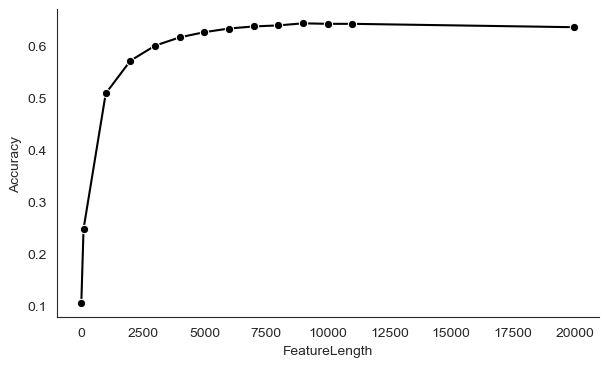

<Figure size 640x480 with 0 Axes>

In [8]:
sns.set_style('white')
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['patch.edgecolor'] = 'white'

plt.figure(figsize=(7, 4))
sns.lineplot(x='FeatureLength', y='Accuracy', data=df_results, markers=True, dashes=False, marker="o", color='black')
plt.show()
plt.savefig('../visuals/TF_IDF_SVM_Accuracy.png', );